In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Importing data and libs**

In [ ]:
# Standard packages
import json

# Libs to deal with tabular data
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd

# Plotting packages
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import matplotlib.pyplot as plt

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

# Lib to create maps
import folium 
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# To display stuff in notebook
from IPython.display import display, Markdown


In [ ]:
import random
import folium


### **Load data**

Như bạn có thể thấy từ mô tả của tập dữ liệu, nó cung cấp bốn tệp dữ liệu.

Kernel này sẽ sử dụng dữ liệu sau:

*   Measure_summary.csv với bản tóm tắt thông tin
*   Measurement_item_info.csv với thông tin về các chất ô nhiễm
*   Measurement_station_info.csv với thông tin về trạm đo


In [ ]:
# Reading Air Pollution in Seoul
stations = pd.read_csv('/content/drive/MyDrive/BigData/Original Data/Measurement_station_info.csv')
measurements = pd.read_csv('/content/drive/MyDrive/BigData/Original Data/Measurement_info.csv')
items = pd.read_csv('/content/drive/MyDrive/BigData/Original Data/Measurement_item_info.csv')

In [ ]:
pollutions = pd.read_csv('/content/drive/MyDrive/BigData/Measurement_summary.csv')

Link github: https://github.com/southkorea/seoul-maps

In [ ]:
# Reading GeoJSON with Seoul administrative borders
with open('/content/drive/MyDrive/BigData/Korean 2015/seoul_municipalities_geo_simple.json', 'r') as file:
    district_borders = json.loads(file.read())

### **Data preparation** 
**Pollutants**

Bảng này hiển thị thông tin về từng chất ô nhiễm, chẳng hạn như đơn vị đo lường và mức chất lượng.

In [ ]:
print('Shape:', items.shape)
items

Shape: (6, 7)


Item code Item name Unit of measurement  Good(Blue)  Normal(Green)  \
0          1       SO2                 ppm        0.02           0.05   
1          3       NO2                 ppm        0.03           0.06   
2          5        CO                 ppm        2.00           9.00   
3          6        O3                 ppm        0.03           0.09   
4          8      PM10       Mircrogram/m3       30.00          80.00   
5          9     PM2.5       Mircrogram/m3       15.00          35.00   

   Bad(Yellow)  Very bad(Red)  
0         0.15            1.0  
1         0.20            2.0  
2        15.00           50.0  
3         0.15            0.5  
4       150.00          600.0  
5        75.00          500.0

Column data types

In [ ]:
items.dtypes

Item code                int64
Item name               object
Unit of measurement     object
Good(Blue)             float64
Normal(Green)          float64
Bad(Yellow)            float64
Very bad(Red)          float64
dtype: object

Parsing data and creating auxiliar structures

In [ ]:
# Adding unit to the item name
items['Item name (unit)'] = items['Item name'] + ' (' + items['Unit of measurement'].str.lower() + ')'

# Creating a dict of item codes to item names.
items_dict = {row['Item code']: row['Item name (unit)'] for idx, row in items.iterrows()}

In [ ]:
# This is a function generator that creates functions to say if a measurement is good, normal, bad or very bad.
def evaluation_generator(good, normal, bad, vbad):
    def measurement_evaluator(value):
        if(pd.isnull(value) or value < 0):
            return np.nan
        elif(value <= good):
            return 'Good'
        elif(value <= normal):
            return 'Normal'
        elif(value <= bad):
            return 'Bad'
        else:
            return 'Very bad'
        
    return measurement_evaluator

# A dictionary that maps pollutants to functions that evaluate the measurement level.
evaluators = {
    row['Item name (unit)']: evaluation_generator(row['Good(Blue)'], row['Normal(Green)'], row['Bad(Yellow)'], row['Very bad(Red)']) 
    for idx, row in items.iterrows()
}

### **Stations**

DataFrame sau đây hiển thị vị trí của từng trạm. Có 25 trạm, mỗi trạm nằm ở một quận khác nhau.

First 5 rows

In [ ]:
print('Shape:', stations.shape)
stations.head()

Shape: (25, 5)


Station code Station name(district)  \
0           101              Jongno-gu   
1           102                Jung-gu   
2           103             Yongsan-gu   
3           104           Eunpyeong-gu   
4           105           Seodaemun-gu   

                                             Address   Latitude   Longitude  
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008  
1  15, Deoksugung-gil, Jung-gu, Seoul, Republic o...  37.564263  126.974676  
2  136, Hannam-daero, Yongsan-gu, Seoul, Republic...  37.540033  127.004850  
3  215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...  37.609823  126.934848  
4  32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...  37.593742  126.949679

Column data types

In [ ]:
stations.dtypes

Station code                int64
Station name(district)     object
Address                    object
Latitude                  float64
Longitude                 float64
dtype: object

Parsing data and creating auxiliar structures

In [ ]:
stations_dict = {row['Station code']: row['Station name(district)'] for idx, row in stations.iterrows()}

### **Measurements** 

Bảng này chứa chuỗi thời gian 150 (25 phân vùng và 6 chất ô nhiễm) được xếp chồng lên nhau trong một DataFrame duy nhất. Mỗi hàng đại diện cho phép đo của một trạm cụ thể và một chất ô nhiễm cụ thể. Giá trị được trình bày ở đây trong cột 'Giá trị trung bình' là giá trị trung bình của nồng độ khí hoặc hạt trong khung thời gian 1 giờ trước ngày được chỉ định trong cột 'Ngày đo'.

Lưu ý rằng các thiết bị không hoạt động 24/7 vì chúng đôi khi có thể cần sửa chữa hoặc hiệu chuẩn. Vì vậy, trong tập dữ liệu này, chúng ta có thể có các phép đo có vấn đề. Dưới đây, bạn có thể thấy một lệnh Python chứa một ánh xạ từ mã trạng thái công cụ đến mô tả.

Five random rows

In [ ]:
print('Shape:', measurements.shape)
measurements.sample(5, random_state=42)

Shape: (3885066, 5)


Measurement date  Station code  Item code  Average value  \
1477361  2018-02-15 09:00           102          9         11.000   
610731   2017-06-19 15:00           114          6          0.103   
1503666  2018-02-22 16:00           112          1          0.006   
458701   2017-05-08 10:00           101          3          0.034   
1347440  2018-01-10 06:00           124          5          0.300   

         Instrument status  
1477361                  0  
610731                   0  
1503666                  0  
458701                   0  
1347440                  0

Column data types

In [ ]:
measurements.dtypes

Measurement date      object
Station code           int64
Item code              int64
Average value        float64
Instrument status      int64
dtype: object

Parsing data and creating auxiliar structures

In [ ]:
# Pivoting table to reduce number of rows
measures = measurements.pivot_table(index=['Measurement date', 'Station code', 'Instrument status'], columns='Item code', values='Average value').reset_index()
measures.columns = measures.columns.rename('')

In [ ]:
# Replacing meaningless numbers by labels 
intrument_status = {
    0: 'Normal',
    1: 'Need for calibration',
    2: 'Abnormal',
    4: 'Power cut off',
    8: 'Under repair',
    9: 'Abnormal data',
}
measures['Instrument status'] = measures['Instrument status'].replace(intrument_status)
measures['Station code'] = measures['Station code'].replace(stations_dict)
measures = measures.rename(columns=items_dict)

# Renaming columns
measures = measures.rename(columns={
    'Measurement date': 'Date',
    'Station code': 'Station',
    'Instrument status': 'Status'
})

# Adding levels 
for pol, func in evaluators.items():
    measures[pol.split()[0] + ' Level'] = measures[pol].map(func)
    
# Casting
measures['Date'] = pd.to_datetime(measures['Date'])

# Adding date related columns
weekday_dict = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}
measures['Month'] = measures['Date'].dt.month
measures['Year'] = measures['Date'].dt.year
measures['Hour'] = measures['Date'].dt.hour
measures['Day'] = measures['Date'].dt.weekday.replace(weekday_dict)

First five rows of the parsed measurements dataset

In [ ]:
print('Shape:', measures.shape)
measures.head()

Shape: (680175, 19)


Date       Station  Status  SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
0 2017-01-01     Jongno-gu  Normal      0.004      0.059       1.2     0.002   
1 2017-01-01       Jung-gu  Normal      0.006      0.068       1.3     0.002   
2 2017-01-01    Yongsan-gu  Normal      0.005      0.039       1.4     0.002   
3 2017-01-01  Eunpyeong-gu  Normal      0.005      0.045       0.6     0.003   
4 2017-01-01  Seodaemun-gu  Normal      0.005      0.044       1.0     0.004   

   PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3) SO2 Level NO2 Level CO Level  \
0                  73.0                   57.0      Good    Normal     Good   
1                  77.0                   63.0      Good       Bad     Good   
2                  70.0                   68.0      Good    Normal     Good   
3                  73.0                   46.0      Good    Normal     Good   
4                  81.0                   44.0      Good    Normal     Good   

  O3 Level PM10 Level PM2.5 Level  Month  Year  Hour     Day  
0     Good     Normal         Bad      1  2017     0  Sunday  
1     Good     Normal         Bad      1  2017     0  Sunday  
2     Good     Normal         Bad      1  2017     0  Sunday  
3     Good     Normal         Bad      1  2017     0  Sunday  
4     Good        Bad         Bad      1  2017     0  Sunday

First and last date

In [ ]:
print('First date:', str(measures['Date'].min()))
print('Last date:', str(measures['Date'].max()))

First date: 2017-01-01 00:00:00
Last date: 2019-12-31 23:00:00


### **Exploratory analysis** 
**Where are stations located?** 

Nồng độ các chất ô nhiễm được báo cáo có thể khác nhau tùy thuộc vào địa chỉ của các trạm. Nói cách khác, các ga gần khu vực đông dân cư có thể mang lại giá trị cao hơn so với các khu vực có nhiều công viên hơn hoặc thiên nhiên được bảo tồn. Dưới đây, bạn có thể thấy so sánh các vị trí ga và ranh giới các huyện. Lưu ý rằng các vị trí ga trong mỗi quận khác nhau và có những khu vực được bao phủ tốt hơn những khu vực khác. Ví dụ, ở khu vực trung tâm của Seoul, ga Dongdaemun-gu và Jongno-gu rất gần nhau. Tuy nhiên, có một phần lớn diện tích đất chưa được khai phá ở phía nam.

Bấm vào điểm đánh dấu để xem tên quận!

In [ ]:
stations_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

# Add points to the map
for idx, row in stations.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(stations_map)
    
# Adding borders
folium.GeoJson(
    district_borders,
    name='geojson'
).add_to(stations_map)

# Display the map
stations_map

### **Pollution levels**

Để có một cái nhìn tổng quan công bằng về tình trạng ô nhiễm ở Seoul, trước tiên tôi loại bỏ các quan sát bằng dụng cụ không được coi là bình thường. Sau đó, tôi tính trung bình các mức ô nhiễm của mỗi quận để có một giá trị duy nhất đại diện cho chất lượng không khí chung của thành phố cho từng chất ô nhiễm và dấu thời gian. Nói cách khác, tôi đã biến đổi chuỗi thời gian 150 (25 x 6) chỉ trong 6 bằng cách lấy trung bình các nồng độ của quận.

In [ ]:
bad_measures = measures.loc[measures['Status'] != 'Normal', :]
all_measures = measures.copy()
measures = measures.loc[measures['Status'] == 'Normal', :]
overview = measures.groupby('Date').mean().loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']

# Adding levels 
for pol, func in evaluators.items():
    overview[pol.split()[0] + ' Level'] = overview[pol].map(func)

Five random rows of Seoul pollution levels

In [ ]:
print('Shape:', overview.shape)
overview.sample(5, random_state=42)

Shape: (25906, 12)


SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
Date                                                            
2019-10-16 09:00:00   0.003591   0.031091  0.522727  0.009727   
2019-05-21 00:00:00   0.004080   0.018480  0.416000  0.026160   
2019-12-09 12:00:00   0.003957   0.043261  0.713043  0.005913   
2018-01-11 02:00:00   0.004870   0.011708  0.430435  0.019708   
2017-02-13 13:00:00   0.006720   0.048480  0.644000  0.012640   

                     PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3) SO2 Level  \
Date                                                                         
2019-10-16 09:00:00             29.238095              14.100000      Good   
2019-05-21 00:00:00             48.720000              17.120000      Good   
2019-12-09 12:00:00             69.913043              49.521739      Good   
2018-01-11 02:00:00             32.166667              19.458333      Good   
2017-02-13 13:00:00             48.916667              29.375000      Good   

                    NO2 Level CO Level O3 Level PM10 Level PM2.5 Level  
Date                                                                    
2019-10-16 09:00:00    Normal     Good     Good       Good        Good  
2019-05-21 00:00:00      Good     Good     Good     Normal      Normal  
2019-12-09 12:00:00    Normal     Good     Good     Normal         Bad  
2018-01-11 02:00:00      Good     Good     Good     Normal      Normal  
2017-02-13 13:00:00    Normal     Good     Good     Normal      Normal

Pollution levels along the three years time span

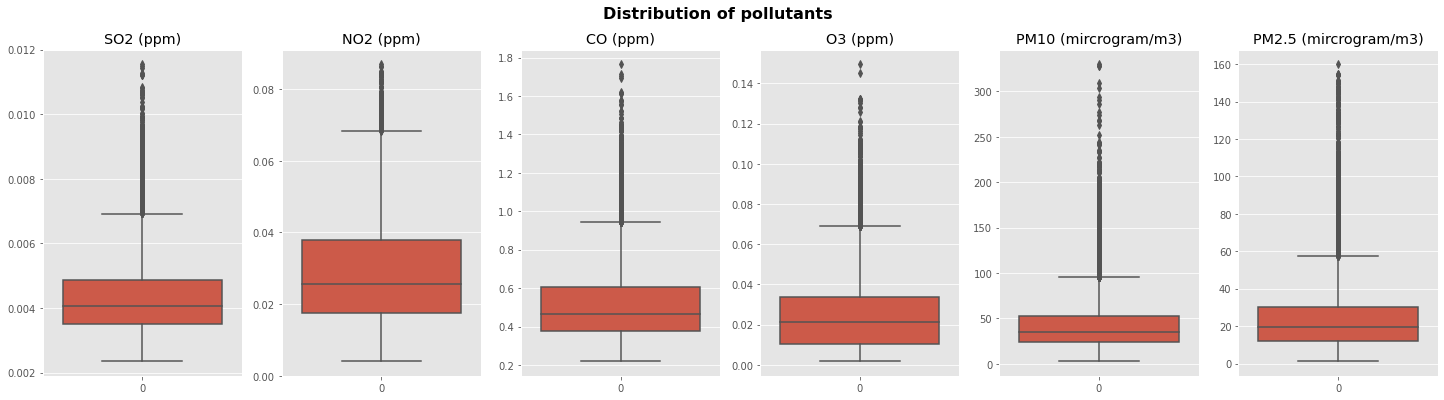

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(25, 6))
fig.suptitle('Distribution of pollutants', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.boxplot(data = overview[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.show()

*Theo đồ thị hình hộp ở trên, hình dạng của các phân bố gần giống như một cái chuông (bình thường) nhưng hơi lệch sang phải. Ngoài ra, hãy lưu ý rằng có số lượng ngoại lệ, đặc biệt là trong các bản phân phối PM10 và PM2.5.*

In [ ]:
general = overview.describe().loc[['min', 'max', 'mean', 'std', '25%', '50%', '75%'],:].T
general['level'] = None
for idx, row in general.iterrows():
    general.loc[idx, 'level'] = evaluators[idx](row['mean'])
    
general.T

SO2 (ppm) NO2 (ppm)  CO (ppm)  O3 (ppm) PM10 (mircrogram/m3)  \
min    0.002364  0.004125  0.220833   0.00188                 3.12   
max    0.011542  0.086875     1.764   0.14944           329.583333   
mean   0.004318  0.028622  0.516274  0.024373            41.573386   
std    0.001092  0.014137  0.197037  0.017895             27.83169   
25%     0.00352   0.01752  0.378261  0.010333            23.583333   
50%     0.00408    0.0256  0.463636  0.021091                 35.5   
75%     0.00488   0.03788     0.604    0.0338            52.275217   
level      Good      Good      Good      Good               Normal   

      PM2.5 (mircrogram/m3)  
min                    1.36  
max                  159.84  
mean              24.011181  
std               17.876667  
25%                   12.24  
50%               19.673333  
75%                   30.32  
level                Normal

*Như chúng ta có thể thấy ở trên, mức độ ô nhiễm ở Seoul là tốt. Mặc dù là một trong những thành phố lớn nhất thế giới và đang được đô thị hóa dày đặc, nó có khả năng kiểm soát các chất ô nhiễm rất tốt. Hai điểm có thể được cải thiện là nồng độ PM10 và PM2.5, chỉ được coi là bình thường.*



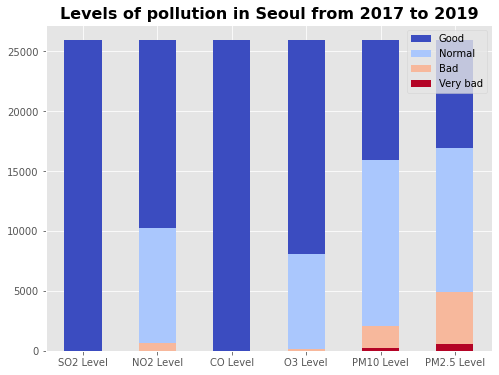

In [ ]:
level_counts = pd.concat([overview[col].value_counts() for col in overview.loc[:, 'SO2 Level':]], axis=1, join='outer', sort=True).fillna(0.0)
level_counts = level_counts.loc[['Very bad', 'Bad', 'Normal', 'Good'], :]

level_counts.T.plot(kind='bar', stacked=True, figsize=(8,6), rot=0,
                    colormap='coolwarm_r', legend='reverse')
plt.title('Levels of pollution in Seoul from 2017 to 2019', fontsize=16, fontweight='bold')
plt.show()

*Biểu đồ này cho thấy số lượng của từng mức độ ô nhiễm trong ba năm quan sát được. Bên cạnh việc có mức độ tổng thể tốt, cốt truyện cho thấy Seoul đôi khi vẫn có thể có nồng độ khí và hạt xấu hoặc rất xấu.*

**Does pollutants have correlation?**

Chúng ta biết rằng ô tô và các ngành công nghiệp là những tác nhân gây ra lượng khí thải ô nhiễm lớn. Ngoài ra, rất phổ biến là chúng thải ra nhiều loại khí cùng một lúc. Ví dụ, các phương tiện cơ giới thường thải ra cả CO và NO2. Vì vậy, chúng tôi ngoại trừ một số mức độ tương quan giữa các chuỗi thời gian.

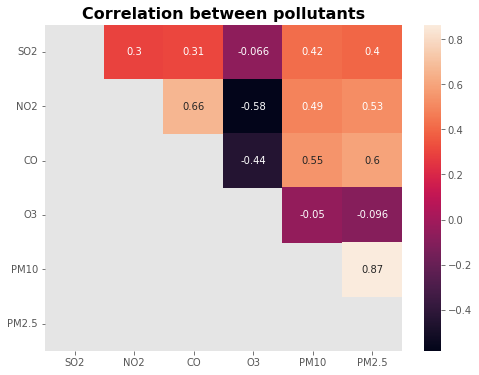

In [ ]:
measures_slice = measures.loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']
measures_slice.columns = list(map(lambda x: x.split()[0], measures_slice.columns))
correlations = measures_slice.corr(method='spearman')
mask = np.zeros_like(correlations)
mask[np.tril_indices_from(mask)] = True

plt.figure(figsize=(8,6))
ax = sns.heatmap(data=correlations, annot=True, mask=mask, color=sns.color_palette("coolwarm", 7))
plt.title('Correlation between pollutants', fontsize=16, fontweight='bold')
plt.xticks(rotation=0) 
plt.yticks(rotation=0) 
plt.show()

*Như chúng ta thấy ở trên, hầu hết các tổ hợp biến đều có tương quan tuyệt đối lớn hơn 0,3. Hai mối tương quan hàng đầu là giữa CO và NO2 và PM10 và PM2.5. Vì vậy giả thuyết của chúng tôi về lượng khí thải xe cộ đã được chứng minh là đúng.*

### **How pollutant concentrations varies with location?** 

Để phân tích dữ liệu về mặt địa lý, trước tiên tôi tính toán nồng độ trung bình của từng chất ô nhiễm cho mỗi vùng. Nhưng ở đây chúng ta phải đối mặt với một vấn đề là các chất ô nhiễm có các đơn vị đo lường khác nhau. Vì vậy, tôi cũng đã chuẩn hóa 6 phân bố chất ô nhiễm, mỗi phân bố có 25 điểm (quận).

Trong bản đồ nhiệt sau đây, thang đo là lượng độ lệch chuẩn so với giá trị trung bình (điểm Z). Giá trị âm cho biết mức độ ô nhiễm dưới mức trung bình và giá trị dương cho thấy điều ngược lại.

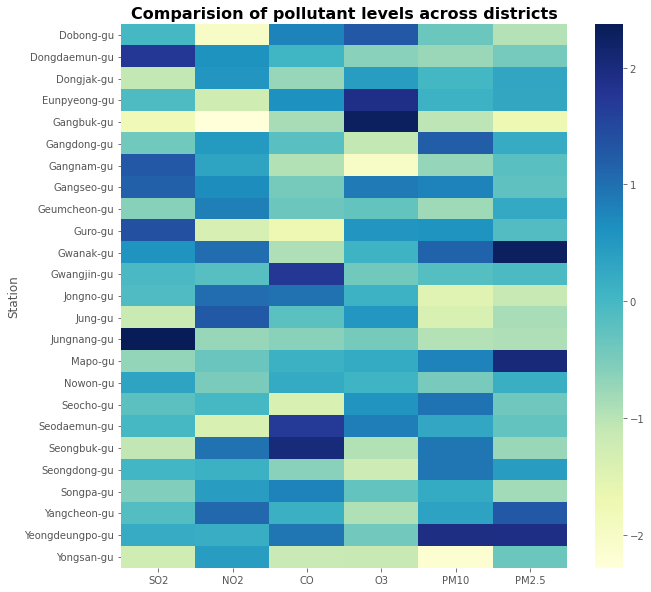

In [ ]:
district_pol = measures.groupby(['Station']).mean().loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']
district_pol_norm = (district_pol - district_pol.mean()) / district_pol.std()
district_pol_norm.columns = list(map(lambda x: x.split(' ')[0],district_pol_norm.columns))

plt.figure(figsize=(10,10))
sns.heatmap(data=district_pol_norm, cmap="YlGnBu")
plt.title('Comparision of pollutant levels across districts', fontsize=16, fontweight='bold')
plt.xticks(rotation=0) 
plt.show()

*Trong các bản đồ dưới đây, bạn sẽ thấy sự phân bố địa lý của các chất ô nhiễm. Tất nhiên chúng ta không thể khái quát thông tin thu thập được ở một điểm cụ thể cho toàn bộ khu vực, nhưng nó là một chỉ báo tốt về đặc điểm của huyện.*

In [ ]:
for col in district_pol_norm.columns:
    pollutant_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

    # Add points to the map
    for idx, row in stations.iterrows():
        Marker([row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(pollutant_map)

    # Adding choropleth
    Choropleth(
        geo_data=district_borders,
        data=district_pol_norm[col], 
        key_on="feature.properties.SIG_ENG_NM", 
        fill_color='YlGnBu', 
        legend_name='Concentration of {} in Seoul (Z-score)'.format(col)
    ).add_to(pollutant_map)
    
    display(Markdown('<center><h3>{}</h3></center>'.format(col)))
    display(pollutant_map)

<center><h3>SO2</h3></center>

<center><h3>NO2</h3></center>

<center><h3>CO</h3></center>

<center><h3>O3</h3></center>

<center><h3>PM10</h3></center>

<center><h3>PM2.5</h3></center>

# **What are the most and least polluted regions of Seoul?**

Để trả lời câu hỏi này, tôi đã tính toán điểm Z trung bình của bản đồ nhiệt trước đó và đưa ra một giá trị duy nhất đại diện cho mức độ ô nhiễm của mỗi vùng. Bản đồ hiển thị các giá trị này có thể được nhìn thấy bên dưới.


In [ ]:
pollution_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

# Add points to the map
for idx, row in stations.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(pollution_map)

# Adding choropleth
Choropleth(
    geo_data=district_borders,
    data=district_pol_norm.mean(axis=1), 
    key_on="feature.properties.SIG_ENG_NM", 
    fill_color='YlGnBu', 
    legend_name='Overall pollution in Seoul by region'
).add_to(pollution_map)

pollution_map

## **What really happened on that December 11th?**

Trước tiên, tôi muốn xem xét nồng độ chất ô nhiễm trung bình của 25 quận. Để làm điều đó, tôi sử dụng tổng quan DataFrame.

**City overview**

In [ ]:
reported_day_night = pd.Timestamp(year=2019, month=12, day=11, hour=22)

overview.loc[overview.index == reported_day_night, :]

SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
Date                                                            
2019-12-11 22:00:00   0.002957   0.017522  0.378261  0.019739   

                     PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3) SO2 Level  \
Date                                                                         
2019-12-11 22:00:00                  19.0              12.583333      Good   

                    NO2 Level CO Level O3 Level PM10 Level PM2.5 Level  
Date                                                                    
2019-12-11 22:00:00      Good     Good     Good       Good        Good

*Như bạn có thể thấy, không có gì sai với ô nhiễm vào ngày và giờ được báo cáo trong phần giới thiệu! Nhưng nếu chúng ta xem xét điều này cùng ngày nhưng lúc 10 giờ sáng, thay vào đó, chúng ta xác định những điều sau đây.*

In [ ]:
reported_day_morning = pd.Timestamp(year=2019, month=12, day=11, hour=10)

overview.loc[overview.index == reported_day_morning, :]

SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
Date                                                            
2019-12-11 10:00:00   0.004042     0.0315    0.8625  0.024458   

                     PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3) SO2 Level  \
Date                                                                         
2019-12-11 10:00:00                156.36                 103.96      Good   

                    NO2 Level CO Level O3 Level PM10 Level PM2.5 Level  
Date                                                                    
2019-12-11 10:00:00    Normal     Good     Good   Very bad    Very bad

*Vì vậy, rất có thể đã xảy ra lỗi đánh máy trong bài viết. Lưu ý rằng, mặc dù nồng độ PM10 và PM2.5 thực sự xấu, các chất ô nhiễm khác không bị ảnh hưởng.*

*Nhưng chúng tôi vẫn không nhận được cùng một giá trị được báo cáo bởi vì chúng tôi đang xem xét mức trung bình của thành phố.*

**Records by stations**

In [ ]:
measures.loc[measures['Date'] == reported_day_morning, :'PM2.5 (mircrogram/m3)'].sort_values('PM2.5 (mircrogram/m3)', ascending=False).head(10)

Date        Station  Status  SO2 (ppm)  NO2 (ppm)  \
667475 2019-12-11 10:00:00    Gangdong-gu  Normal      0.003      0.033   
667464 2019-12-11 10:00:00       Nowon-gu  Normal      0.005      0.036   
667462 2019-12-11 10:00:00     Gangbuk-gu  Normal      0.004      0.032   
667468 2019-12-11 10:00:00   Geumcheon-gu  Normal      0.004      0.034   
667470 2019-12-11 10:00:00     Dongjak-gu  Normal      0.004      0.030   
667450 2019-12-11 10:00:00      Jongno-gu  Normal      0.005      0.036   
667459 2019-12-11 10:00:00  Dongdaemun-gu  Normal      0.004      0.032   
667452 2019-12-11 10:00:00     Yongsan-gu  Normal      0.004      0.029   
667451 2019-12-11 10:00:00        Jung-gu  Normal      0.004      0.032   
667456 2019-12-11 10:00:00        Mapo-gu  Normal      0.005      0.037   

        CO (ppm)  O3 (ppm)  PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3)  
667475       0.9     0.022                 192.0                  152.0  
667464       0.9     0.025                 154.0                  133.0  
667462       0.8     0.038                 186.0                  128.0  
667468       0.8     0.019                 150.0                  127.0  
667470       0.8     0.020                 175.0                  125.0  
667450       1.0     0.016                 156.0                  116.0  
667459       0.9     0.022                 166.0                  113.0  
667452       0.9     0.025                 151.0                  110.0  
667451       0.9     0.024                 151.0                  108.0  
667456       0.9     0.021                 143.0                  107.0

*Trong bảng trên, tôi đã hiển thị 10 hàng đầu tiên của các bản ghi chất ô nhiễm trong một giờ chính xác và được sắp xếp theo các giá trị PM2.5. Một lần nữa, chúng tôi không thể thấy giá trị được báo cáo là 118 microgram / m3, nhưng điều này có thể đã xảy ra vì chúng tôi đang thấy giá trị trung bình của một giờ.*

**Comparison to the entire month**

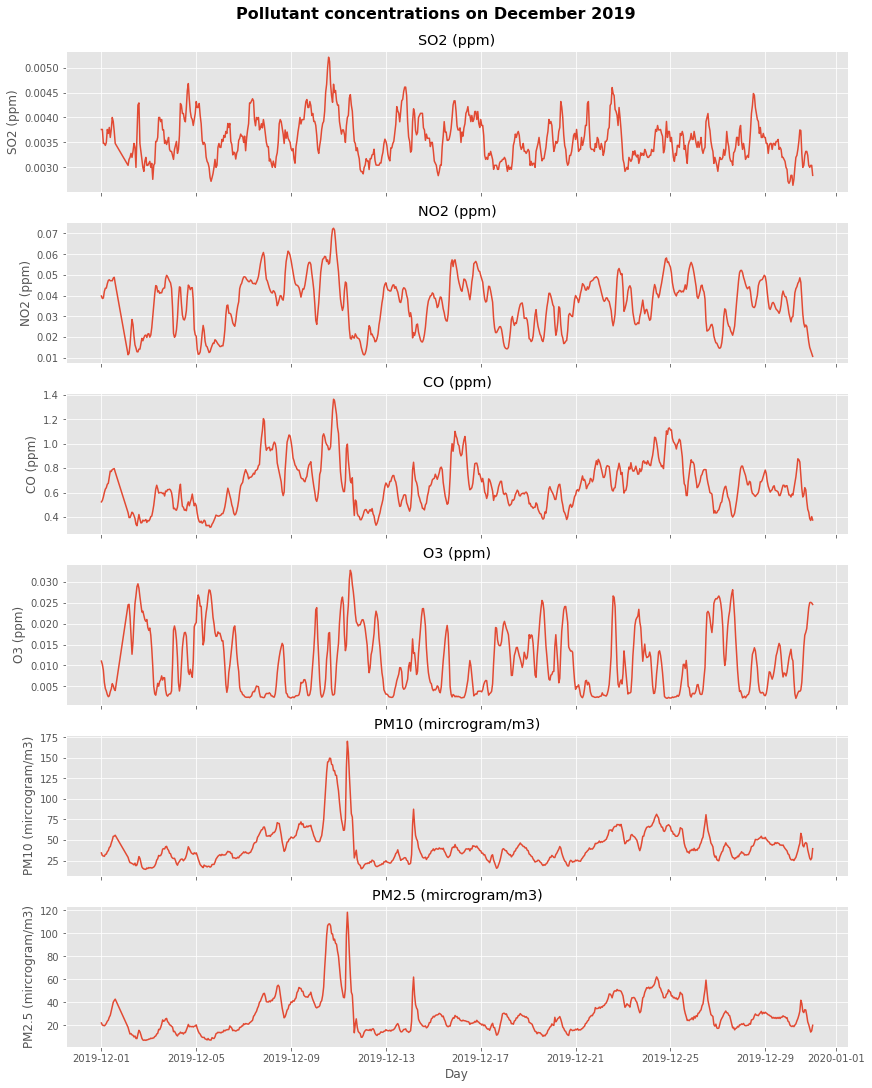

In [ ]:
first_day_dec = pd.Timestamp(year=2019, month=12, day=1)
last_day_dec = pd.Timestamp(year=2019, month=12, day=31)

december = overview.loc[(overview.index >= first_day_dec) & (overview.index <= last_day_dec),:]

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations on December 2019', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = december[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Day')
plt.show()

*Chúng ta có thể thấy rằng tất cả các chất ô nhiễm, ngoại trừ O3, đã tăng đột biến vào giữa tháng. Nhưng mức tăng đột biến này rõ ràng hơn nhiều trong hai chuỗi thời gian gần đây.*

**Does the concentration of pollutants have sazonality and tendency? (to be expanded)**

Để phân tích điều này, trước tiên chúng tôi lấy giá trị trung bình của nồng độ mỗi giờ và chất ô nhiễm

In [ ]:
concentration_hour = measures.groupby('Hour').mean()

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations along the day', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = concentration_hour[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Hour')
plt.show()

*Chắc chắn, mỗi chất ô nhiễm có một hành vi khác nhau. Một số có hai đỉnh mỗi ngày và một số chỉ có một. Nhưng có một điểm chung là tất cả đều có thung lũng vào buổi sáng. Ngoài ra, các chất ô nhiễm được đo bằng ppm có đường cong mượt mà hơn so với các chất ô nhiễm được đo bằng ug / m3.*

*Trong biểu đồ tiếp theo, chúng ta sẽ xem liệu có sự phân hóa và xu hướng trong chuỗi thời gian ô nhiễm hay không.*

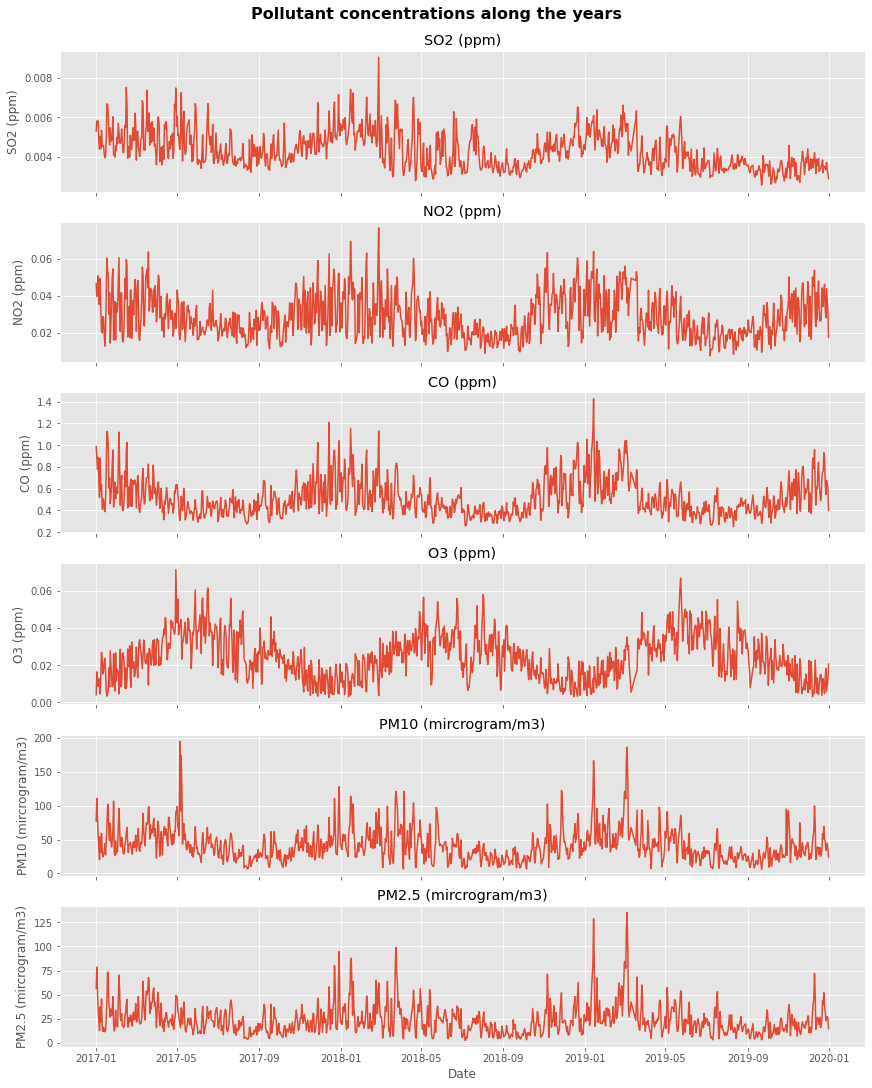

In [ ]:
measures_slice = measures.loc[:, ['Date'] + list(evaluators.keys())]
measures_slice['Date'] = measures['Date'].dt.date
concentrations_day = measures_slice.groupby('Date').mean()

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations along the years', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = concentrations_day[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Date')
plt.show()

# **Appendix** 

**What happens when an instrument doesn't work properly?**

Random sample of rows with problems

In [ ]:
bad_measures.loc[:, 'Status':'PM2.5 (mircrogram/m3)'].sample(10, random_state=42)

Status  SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
625728         Power cut off     -1.000     -1.000      -1.0    -1.000   
339888         Abnormal data        NaN        NaN       NaN       NaN   
115447         Abnormal data        NaN        NaN       NaN       NaN   
605564         Power cut off     -1.000     -1.000      -1.0    -1.000   
417962  Need for calibration      0.081      0.015       3.1     0.005   
586470         Abnormal data        NaN        NaN       NaN       NaN   
623705         Power cut off     -1.000     -1.000      -1.0    -1.000   
462382  Need for calibration      0.000      0.000       0.0     0.000   
187254  Need for calibration      0.000      0.000       0.0     0.000   
616000         Abnormal data        NaN        NaN       NaN       NaN   

        PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3)  
625728                  -1.0                   -1.0  
339888                  64.0                    NaN  
115447                  50.0                    NaN  
605564                  -1.0                   -1.0  
417962                  21.0                   36.0  
586470                   NaN                  985.0  
623705                  -1.0                   -1.0  
462382                   4.0                    0.0  
187254                   0.0                    NaN  
616000                   NaN                   16.0

**Rows where measurements should be discarded but were collected**

In [ ]:
# Showing 
bad_measures.loc[~bad_measures.loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)'].isnull().any(1), 'Status':'PM2.5 (mircrogram/m3)']

Status  SO2 (ppm)  NO2 (ppm)  CO (ppm)  O3 (ppm)  \
602            Power cut off     -1.000     -1.000      -1.0    -1.000   
822            Power cut off      0.000      0.000       0.0     0.000   
847             Under repair      0.007      0.049       0.3     0.007   
956     Need for calibration      0.006      0.037       0.7     0.023   
981     Need for calibration      0.000      0.000       0.0     0.000   
...                      ...        ...        ...       ...       ...   
677558  Need for calibration      0.003      0.019       0.3     0.020   
679243  Need for calibration      0.041      0.027       5.5     0.020   
679269  Need for calibration      0.059      0.036       5.7     0.002   
679833  Need for calibration      0.003      0.013       0.3     0.028   
679860  Need for calibration      0.003      0.008       0.3     0.026   

        PM10 (mircrogram/m3)  PM2.5 (mircrogram/m3)  
602                     -1.0                   -1.0  
822                      0.0                    0.0  
847                     49.0                   30.0  
956                     62.0                   42.0  
981                      0.0                    0.0  
...                      ...                    ...  
677558                  18.0                   14.0  
679243                 176.0                  167.0  
679269                  82.0                   75.0  
679833                  19.0                   10.0  
679860                  17.0                    7.0  

[10145 rows x 7 columns]

*Lưu ý rằng khi trạng thái của thiết bị khác với bình thường, nó vẫn có thể cung cấp các phép đo có vẻ là đúng. Nhưng nó cũng có thể đưa ra những con số bất thường hoặc âm. Vì chúng tôi không biết các thiết bị này hoạt động như thế nào và liệu chúng có thể cung cấp các phép đo đáng tin cậy ngay cả khi cần hiệu chuẩn, nên sẽ tốt hơn nếu chỉ loại bỏ các hàng này.*

**How many times did an instrument have status different of normal?**

Percentage of abnormal measurements: 6.31837394788106


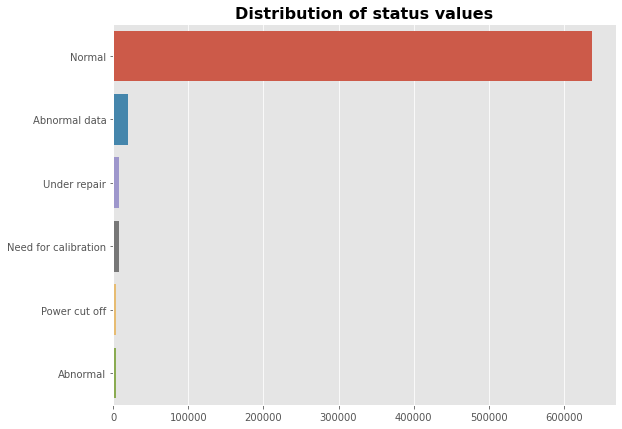

In [ ]:
print('Percentage of abnormal measurements:', bad_measures.shape[0] * 100 / all_measures.shape[0])

counts = all_measures['Status'].value_counts()
plt.figure(figsize=(9,7))
plt.title('Distribution of status values', fontsize=16, fontweight='bold')
sns.barplot(x = counts.values, y = counts.index)
plt.show()

**Is there a pattern in when a instrument stop working?**

To answer this question, we group abnormal rows by hour of the day.

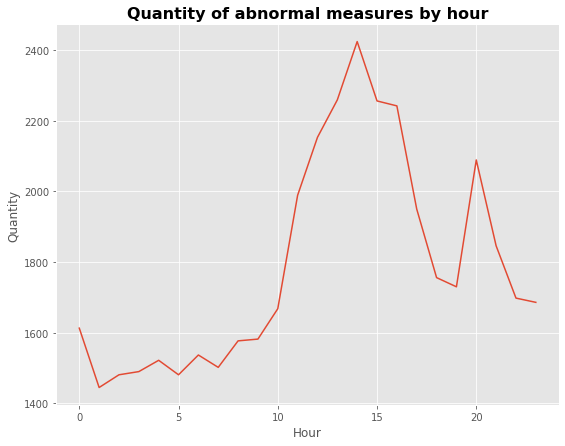

In [ ]:
# Fails by time
#bad_measures.groupby('Year').apply(len)
#bad_measures.groupby('Month').apply(len)
bad_hourly = bad_measures.groupby('Hour').apply(len)

plt.figure(figsize=(9,7))
plt.ylabel('Quantity')
plt.xlabel('Hour')
plt.title('Quantity of abnormal measures by hour', fontsize=16, fontweight='bold')
sns.lineplot(data=bad_hourly)
plt.show()

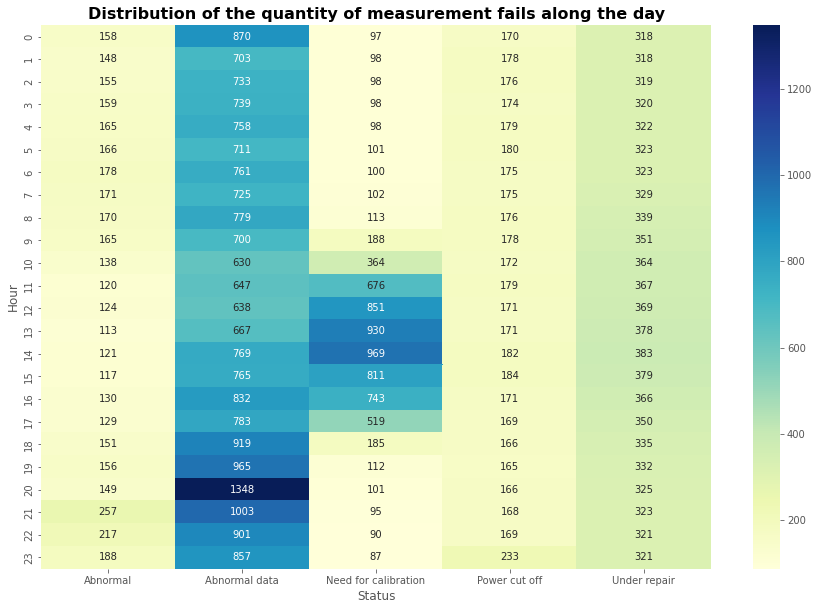

In [ ]:
bad_measures_hour = bad_measures.groupby(['Hour', 'Status']).apply(len).rename('Quantity').reset_index().pivot(index='Hour', columns='Status', values='Quantity').fillna(0).astype('int64')

plt.figure(figsize=(15,10))
plt.title('Distribution of the quantity of measurement fails along the day', fontsize=16, fontweight='bold')
sns.heatmap(data=bad_measures_hour, cmap="YlGnBu", annot=True, fmt='d')
plt.show()

**Chúng ta có thể nhận thấy một số điều theo hai biểu đồ cuối cùng:**


*   An instrument can be under repair approximately any time of the day.However it is slightly more likely that the repair is being conducted during the morning or the evening.
*   Power problems can occur almost anytime.
*   Calibration is more likely to be required in the beggining of the evening.
*   Abnormal data is produced more frequently in the beggining of the afternoon, around 8 p.m.
*   Analysing the distribution of "need for calibration" and "abnormal data" jointly, I can infer that when an equipment starts to behave unexpectedly, it first change status to "need for calibration". After some time it change status again to "abnormal data", since the lack of calibration should make the instrument output weird numbers or even don't output them at all.





 














**Are there regions with more instrument problems?**

In this context, I grouped problems by district.

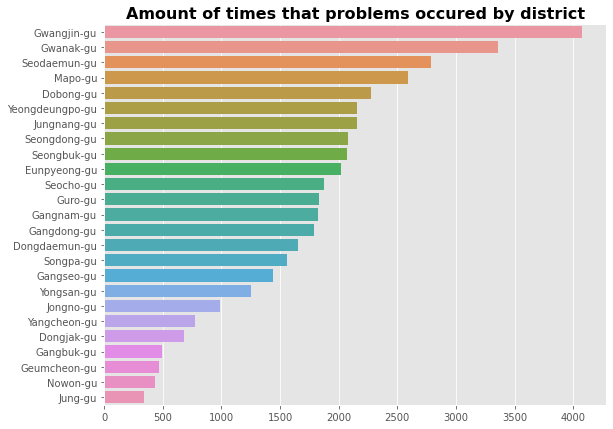

In [ ]:
# Fails by station
bad_stations = bad_measures['Station'].value_counts()

plt.figure(figsize=(9,7))
plt.title('Amount of times that problems occured by district', fontsize=16, fontweight='bold')
sns.barplot(x = bad_stations.values, y = bad_stations.index)
plt.show()

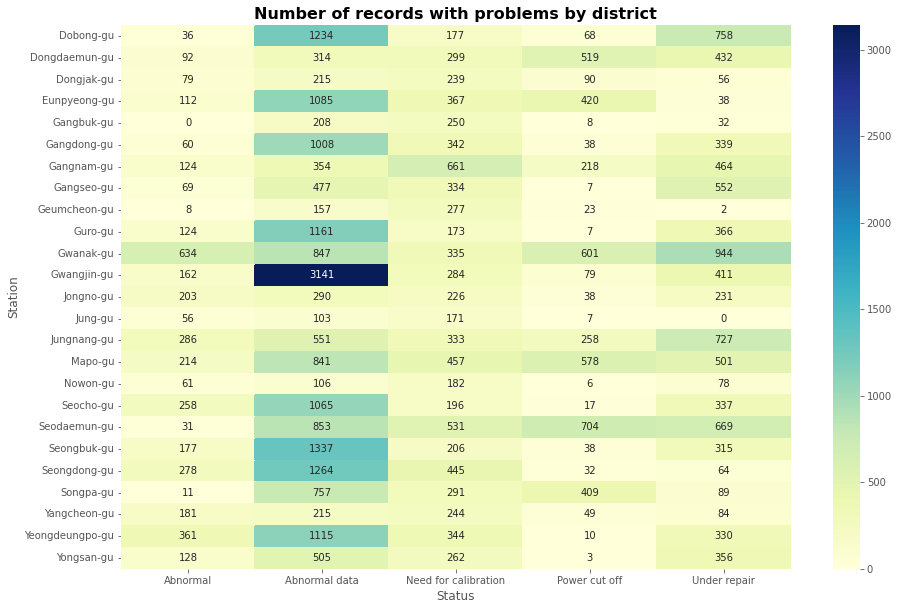

In [ ]:
bad_measures_station = bad_measures.groupby(['Station', 'Status']).apply(len).rename('Quantity').reset_index().pivot(index='Station', columns='Status', values='Quantity').fillna(0).astype('int64')

plt.figure(figsize=(15,10))
sns.heatmap(data=bad_measures_station, cmap="YlGnBu", annot=True, fmt='d')
plt.title('Number of records with problems by district', fontsize=16, fontweight='bold')
plt.show()

*We can observe that some districts have high number of bad status, for instance Gwangjin-gu, Gwanak-gu and Seodaemun-gu. Despite not knowing what really happened in these instruments, I suggest a substitution to see if they present less problems. The instrument in Gwanak-gu is probably old, since it has the highest number of status "under repair".*

### **Visualization**
**Check the location of the measuring station**

Seoul is divided into 25 gu(district). To visualize Seoul by dividing it into different districts, we need a json file containing information on districts.

Using Latitude and Longitude stored in Measurement_station_info.csv, the location of the monitoring station is marked with a marker.

In [ ]:
Ccenter = [37.541, 126.986] # center of Seoul
m = folium.Map(location=center, zoom_start=11) # set map

# Add geojson to folium
folium.GeoJson(
    district_borders,
    name='seoul_municipalities'
).add_to(m)

# Add marker
for i in stations.index[:25]: 
    popup_str = 'Station ' + str(stations.loc[i, 'Station code'])
    folium.Marker(stations.loc[i, ['Latitude', 'Longitude']],
                  popup=popup_str,
                  icon=folium.Icon(color='black')).add_to(m)

m # print

*As you can see on the map above, Seoul is divided into 25 districts. The location of the measuring stations also shows that one measuring station is located in each districts.*

**Markers according to status**

*Measurement_item_info.csv* tells us what the current status is based on the value of the measured item.


*   Good (Blue)
*   Normal (Green)
*   Bad (Yellow)
*   Very bad (Red)

Use these values to visualize the status of different regions by different colors of markers.

(This criteria value may vary from country to country because it is the criteria for air pollutants in Seoul)

In [ ]:
def get_criteria(items, dfitem):
    criteria = items[items['Item name'] == dfitem].iloc[0, 3:]
    return criteria

def seoulmap(df_day, items, dfitem):
    criteria = get_criteria(items, dfitem)
    
    dfm = df_day.copy()
    
    # set color of marker
    dfm['color'] = ''
    dfm.loc[dfm[dfitem] <= criteria[3], 'color'] = 'red'
    dfm.loc[dfm[dfitem] <= criteria[2], 'color'] = 'orange' # yellow
    dfm.loc[dfm[dfitem] <= criteria[1], 'color'] = 'green'
    dfm.loc[dfm[dfitem] <= criteria[0], 'color'] = 'blue'
    
    center = [37.541, 126.986] # center of Seoul
    m = folium.Map(location=center, zoom_start=11) # set map

    folium.GeoJson(
        district_borders,
        name='seoul_municipalities'
    ).add_to(m)

    for i in dfm.index: 
        popup_str = 'Station ' + str(dfm.loc[i, 'Station code']) + ': ' + str(dfm.loc[i, dfitem])
        folium.Marker(dfm.loc[i, ['Latitude', 'Longitude']],
                      popup=popup_str,
                      icon=folium.Icon(color=dfm.loc[i, 'color'])).add_to(m)
    
    return m

In [ ]:
random.seed(0)
ind = random.randint(1, len(pollutions))

day = pollutions.loc[ind, 'Measurement date']
print(day)
df_day = pollutions[pollutions['Measurement date'] == day]

seoulmap(df_day, items, 'PM10')

2018-10-07 05:00


In [ ]:
seoulmap(df_day, items, 'PM2.5')

In [ ]:
random.seed(1)
ind = random.randint(1, len(pollutions))

day = pollutions.loc[ind, 'Measurement date']
print(day)
df_day = pollutions[pollutions['Measurement date'] == day]

seoulmap(df_day, items, 'PM10')

2018-04-20 16:00


In [ ]:
seoulmap(df_day, items, 'PM2.5')

### **TIME SERIES TENSOFLOW**

**Read In Pollution Dataset**

Bộ dữ liệu mà chúng tôi sẽ sử dụng đến từ các cảm biến chất lượng không khí trên khắp Hàn Quốc. Các cảm biến đo và ghi lại tất cả các loại hạt / chất ô nhiễm trong không khí, nhưng đối với hướng dẫn này, chúng ta sẽ chỉ xem xét PM10.

In [ ]:
#Import Libraries
import tensorflow as tf
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import pandas as pd #data manipulation

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.8.2


In [ ]:
#Reads in Pollution csv
pollution = pd.read_csv("/content/drive/MyDrive/BigData/Measurement_summary.csv",
                       parse_dates=['Measurement date'],
                       index_col='Measurement date')
#Filters for only pm10 values in 19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republic of Korea, sorted by date
pollution = pollution[pollution.Address == '19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republic of Korea'].PM10.sort_index()
#starts the dataset at 2018 and ends in 2022(due to breaks in data in previous years)
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('2020-01-01')
pollution = pollution[start:end]
print('SAMPLE OF TIME SERIES DATA:')
pollution.head()

SAMPLE OF TIME SERIES DATA:


Measurement date
2018-01-01 00:00:00    29.0
2018-01-01 01:00:00    27.0
2018-01-01 02:00:00    30.0
2018-01-01 03:00:00    28.0
2018-01-01 04:00:00    28.0
Name: PM10, dtype: float64

**Ẩn ngày bị thiếu**

Dữ liệu chuỗi thời gian đặc biệt nhạy cảm với các giá trị bị thiếu. Vì lý do này, chúng ta cần phải áp dụng bất kỳ bước thời gian nào bị thiếu. Trong tập dữ liệu này, có một số bước thời gian bị thiếu mà chúng tôi sẽ áp dụng giá trị của bước thời gian trước đó.

In [ ]:
#Checks for and imputes missing dates
a = pd.date_range(start="2018-01-01", end="2020-01-01", freq="D") #continous dates
b = pollution.index #our time series
diff_dates = a.difference(b) # finds what in 'a' is not in 'b'

td = pd.Timedelta(1, "d") #1 day
for date in diff_dates:
    prev_val = pollution[date-td] #takes the previous value
    pollution[date] = prev_val #imputes previous value

pollution.sort_index(inplace=True)
#sets the time index frequency as daily
pollution.freq = "D"

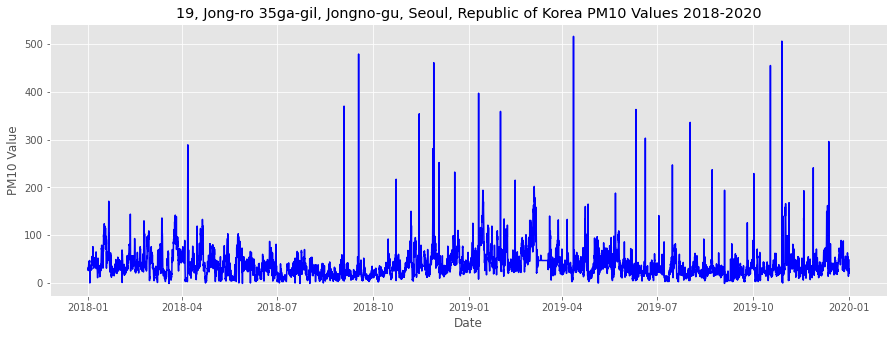

In [ ]:
#displays a plot of the PM10 values since 2018
fig = plt.figure(figsize=(15,5))
plt.plot(pollution, color='blue')
plt.xlabel('Date')
plt.ylabel('PM10 Value')
plt.title('19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republic of Korea PM10 Values 2018-2020')
plt.show()

**Tách tập dữ liệu thành Train / Test**

Bạn có thể đã thực hiện phân tách đào tạo / thử nghiệm trước khi sử dụng các tập hợp con ngẫu nhiên của toàn bộ tập dữ liệu. Trong các bài toán dự báo chuỗi thời gian, dữ liệu kiểm tra cần phải là một khối của các bước thời gian gần đây nhất. Điều này là để ngăn chặn việc tìm kiếm dữ liệu trong mô hình của chúng tôi (có nghĩa là mô hình đã biết trước tương lai).

In [ ]:
#Split the time series data into a train and test set
end_train_ix = pd.to_datetime('2018-12-31')
train = pollution[:end_train_ix] # Jan 2018-2019
test = pollution[end_train_ix:] # Jan 2019-2020

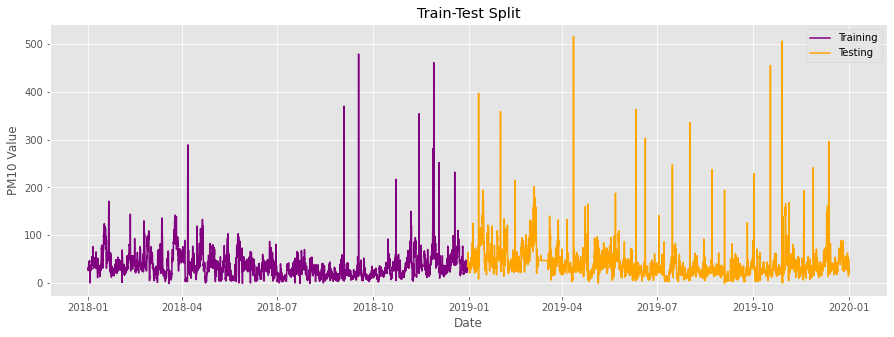

In [ ]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('PM10 Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

**Xử lý tập dữ liệu với Windows**

Dữ liệu chuỗi thời gian cần được chia nhỏ thành các cửa sổ trước khi được gửi đến mô hình ML. Một cửa sổ về cơ bản là một ảnh chụp nhanh trong phạm vi giới hạn của dữ liệu chuỗi thời gian của chúng tôi. Giả sử chúng ta có một mảng giá trị:

[1, 2, 3, 4, 5, 6, 7, 8, 9]

Nếu chúng ta có kích thước cửa sổ là 4 và chúng ta muốn dự báo trước 1 bước thời gian, đây sẽ là kết quả:

[1, 2, 3, 4] [5]

[2, 3, 4, 5] [6]

[3, 4, 5, 6] [7]

[4, 5, 6, 7] [8]

[5, 6, 7, 8] [9]


In [ ]:
#Creates a windowed dataset from the time series data
WINDOW = 14 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values) 

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching 
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(32).prefetch(1)

Train_data bây giờ sẽ có các lô dữ liệu chuỗi thời gian được cửa sổ. Các lô được lấp đầy bởi các mảng giá trị 14 pm10 và giá trị mục tiêu của chúng.

### **CustomCallback**

Các lệnh gọi lại được sử dụng trong Tensorflow để cho phép người dùng can thiệp trong quá trình đào tạo mô hình. Một lệnh gọi lại có thể được thực hiện ở một số ý định cụ thể trong quá trình đào tạo mô hình. Ví dụ:



*   on_batch_begin/end
*   on_epoch_begin/end
*   on_predict_batch_begin/end
*   on_predict_begin/end
*   on_test_batch_begin/end
*   on_test_begin/end
*   on_train_batch_begin/end
*   on_train_begin/end


Chúng tôi sẽ tạo CustomCallback sẽ dừng đào tạo mô hình sau khi mô hình đạt dưới 10 lỗi tuyệt đối có nghĩa là tuyệt đối trên tập hợp đào tạo.

Link: https://keras.io/api/callbacks/

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

### **PredefinedCallback** - LearningRateScheduler

Ngoài ra còn có một số lệnh gọi lại được xác định trước. Chúng tôi sẽ sử dụng LearningRateScheduler để cập nhật động tốc độ học tập của trình tối ưu hóa của chúng tôi. Lệnh gọi lại được xác định trước này thực hiện một thao tác cập nhật tốc độ học tập như một đối số.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

### **LSTM model**

Các lớp LSTM (Bộ nhớ ngắn hạn dài) nhận biết trình tự và có thể mang ý nghĩa từ các bước thời gian trước đó. Các lớp này rất thường được sử dụng trong tất cả các tác vụ học máy mà thứ tự là quan trọng - bao gồm dự báo chuỗi thời gian.

Ưu điểm:

*   Có thể giữ lại thông tin từ xa trong quá khứ để đưa ra dự đoán của nó
*   Đã được chứng minh là có hiệu quả cao

Nhược điểm:

*   Nhiều thông số
*   Thời gian đào tạo dài

Liên kết: https://en.wikipedia.org/wiki/Long_short-term_memory

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]), 
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 14, 1)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 14, 256)          133120    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
#Trains LSTM Model
lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

MAE under 10.0... Stopping training


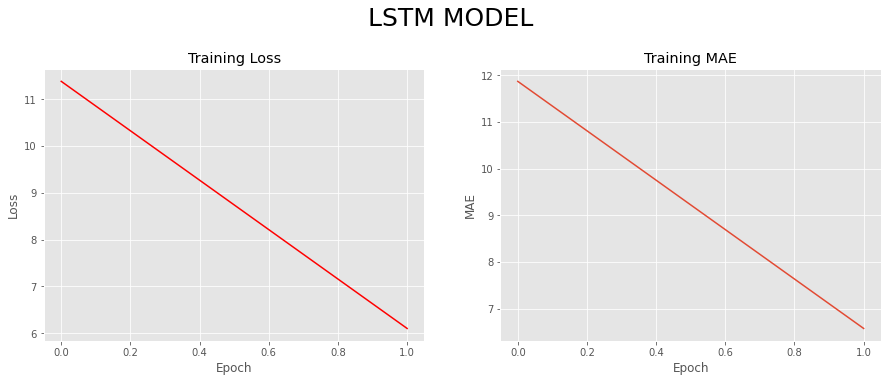

					FINAL LOSS: 6.1 | FINAL MAE: 6.58


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mae'][-1] ,2)))

# **Convolution model**

Các lớp 2D Convolution thường được sử dụng trong các tác vụ thị giác máy tính. Phiên bản 1D của họ có thể được sử dụng cho dữ liệu chuỗi thời gian. Lớp tích chập 1D cố gắng tìm các mẫu trong các phân đoạn khác nhau của dữ liệu chuỗi thời gian.

Ưu điểm:

*   Thông số thấp
*   Thời gian đào tạo nhanh chóng

Nhược điểm:

*   LCó xu hướng đặt nhiều trọng lượng hơn vào các giá trị gần đây

Link: https://boostedml.com/2020/04/1-d-convolutional-neural-networks-for-time-series-basic-intuition.html

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten


cnn_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=32, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=3, strides=1, 
           padding='causal', activation='relu'),
    GlobalAveragePooling1D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

cnn_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 32)            128       
                                                                 
 conv1d_4 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
#Trains CNN Model
cnn_history = cnn_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

MAE under 10.0... Stopping training


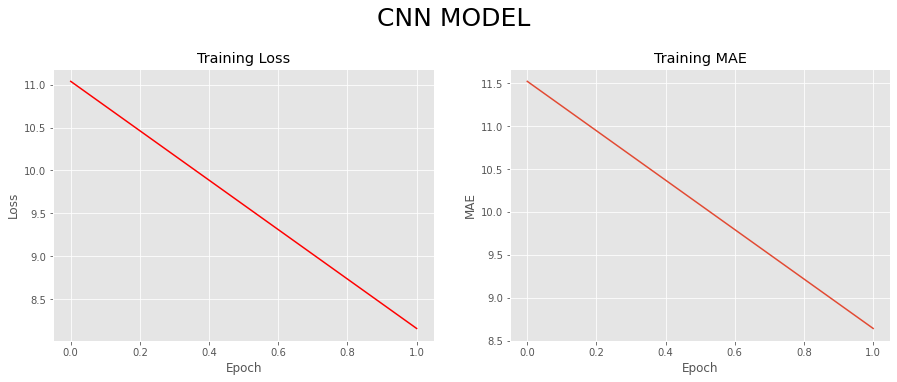

					FINAL LOSS: 8.16 | FINAL MAE: 8.64


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(cnn_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(cnn_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'CNN MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(cnn_history.history['loss'][-1], 2),
                                                 round(cnn_history.history['mae'][-1], 2)))

# **Mixed Architecture Model**

If we are trying to get the best of both worlds, we can mix the Convolution layers with the LSTM layers.

In [ ]:
mixed_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 14, 64)            256       
                                                                 
 bidirectional_6 (Bidirectio  (None, 14, 256)          197632    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 512)              

In [ ]:
#Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

MAE under 10.0... Stopping training


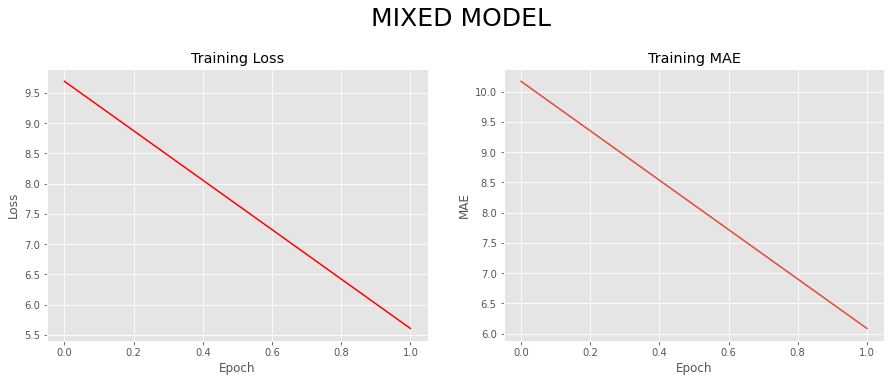

					FINAL LOSS: 5.61 | FINAL MAE: 6.08


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(mixed_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'MIXED MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(mixed_history.history['loss'][-1], 2),
                                                 round(mixed_history.history['mae'][-1], 2)))

# **Evaluate Models on Test Set**

Không giống như các tác vụ học máy khác, chúng tôi không thể dự đoán và đánh giá trực tiếp hiệu suất của mô hình từ dữ liệu thử nghiệm. Đầu tiên, chúng ta phải tạo các cửa sổ (tương tự như cách chúng ta đã làm trên dữ liệu huấn luyện) vào 14 ngày cuối cùng của tập huấn luyện và tập kiểm tra. Mỗi cửa sổ có độ dài 14 này sẽ tương ứng với một bước thời gian của dữ liệu thử nghiệm. Dự đoán giá trị tiếp theo cho mỗi cửa sổ này sẽ là dự báo của chúng tôi.

In [ ]:
#Gets forecasts of models
#Nhận dự báo về các mô hình

all_models = [('LSTM MODEL', lstm_model),
              ('CNN MODEL', cnn_model),
              ('MIXED MODEL', mixed_model)]

model_forecasts = {
    'LSTM MODEL': [],
    'CNN MODEL': [],
    'MIXED MODEL': []
}

#Đoạn dữ liệu được tạo cửa sổ để mỗi cửa sổ được liên kết với một giá trị trong bộ thử nghiệm

forecast_data = train[-WINDOW:].append(test[:-1]).values

for name, model in all_models:
    #Chuyển đổi giá trị thành TensorSliceDataset
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data) 
    #Lấy các phiến kích thước cửa sổ của tập dữ liệu
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)
    #Làm phẳng dữ liệu có cửa sổ bằng cách phân lô
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW+1))
    #Tạo hàng loạt cửa sổ
    test_data = test_data.batch(32).prefetch(1)
    #Nhận dự đoán mô hình
    preds = model.predict(test_data)
    #Thêm vào mục dự báo
    model_forecasts[name].append(preds)

In [ ]:
#Gets MAE score of model forecasts

N = test.values.shape[0] #number of samples in test set

lstm_mae = np.abs(test.values - model_forecasts['LSTM MODEL'][0].squeeze()).sum() / N

cnn_mae = np.abs(test.values - model_forecasts['CNN MODEL'][0].squeeze()).sum() / N

mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N


print('MODEL MAE SCORES')
print('=====================================')
print('LSTM MAE:', round(lstm_mae, 2))
print('CNN MAE:', round(cnn_mae, 2))
print('MIXED MAE:', round(mix_mae, 2))

MODEL MAE SCORES
LSTM MAE: 7.78
CNN MAE: 9.78
MIXED MAE: 6.26


In [ ]:
#displays forecasted data
plt.rcParams["figure.figsize"] = (15,20)
fig, axs = plt.subplots(4, 1)

#LSTM Forecast
axs[0].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[0].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[0].set_title('LSTM MODEL FORECAST')
axs[0].legend()

#CNN Forcast
axs[1].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[1].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[1].set_title('CNN MODEL FORECAST')
axs[1].legend()

#Mixed Model Forecast
axs[2].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[2].set_title('MIXED MODEL FORECAST')
axs[2].legend()

#All forecasts
axs[3].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[3].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[3].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[3].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[3].set_title('ALL MODEL FORECASTS')
axs[3].legend()


plt.show()